# SWOT



In [1]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv
from holoviews import opts
import matplotlib as mpl
import numpy as np

hv.extension('bokeh')

## Select the reservoir

In [2]:
RESERVOIR = '0938'

start_date = '2022-01-01'
end_date = '2024-10-30'

buffer_amt = 1000 # meters

swot_save_dir = Path('../data/swot/raw')

In [5]:
# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/2023-24-insitu-pts.geojson').absolute())
val_polys = gpd.read_file(Path('../data/validation-locations/2023-24-insitu-poly.geojson'))

selected_reservoirs = val_pts['tmsos_id'].tolist()
res_names = val_pts[['tmsos_id', 'name']].set_index('tmsos_id').to_dict()['name']

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

RESERVOIR_NAME = res_names[RESERVOIR]
print(f'{RESERVOIR}: {RESERVOIR_NAME}')

global_map = (
    val_res_pt.hvplot(
        geo=True, tiles='OSM'
    ) * val_res_pt[val_res_pt['tmsos_id'] == RESERVOIR].hvplot(
        geo=True, color='red', size=100, 
    )
).opts(
    title=f"Locations of validation reservoirs. {RESERVOIR_NAME}, highlighted in red"
)

global_map

0938: Lake Sherburne, US


:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

<Axes: >

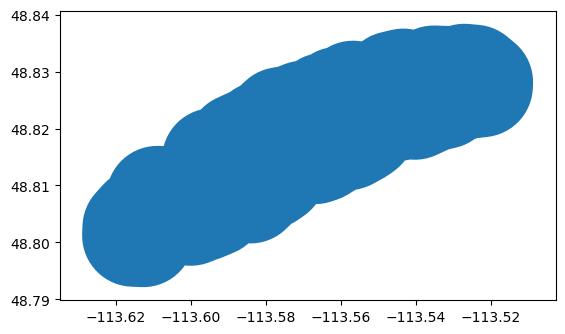

In [6]:
roi = val_res_poly[val_res_poly['tmsos_id']==RESERVOIR]
utm_crs = roi.estimate_utm_crs()
buffered_roi_utm = roi.to_crs(utm_crs).geometry.buffer(buffer_amt)
buffered_roi = buffered_roi_utm.to_crs('epsg:4326')
buffered_roi.plot()

In [7]:
gd_track_fn = Path('../data/swot_orbit/swot_orbit.geojson')
gd_track = gpd.read_file(gd_track_fn)

In [8]:
gd_track_subset = gd_track[gd_track.intersects(buffered_roi.geometry.values[0])]

roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME
roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

cmap = mpl.colormaps['inferno']
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('ID_PASS')))]
tracks_hv = gd_track_subset.hvplot(
    geo=True, tiles='OSM', color=gd_track_subset['color'], alpha=0.5, line_width=2,
    xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1),
    ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1),
    tools=['hover'], hover_cols=['ID_PASS']
)

(tracks_hv * roi_hv).opts(
    title=f"SWOT Ground Tracks over {RESERVOIR_NAME}", width=400
)

/tiger1/pdas47/tmsosPP/.env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (_color,ID_PASS)
   .Polygons.II :Polygons   [Longitude,Latitude]

## SWOT KaRin
### determine pass number

In [9]:
matches = gd_track[gd_track.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
pass_ids = list(matches.ID_PASS)
print(f'Passes: {pass_ids}')

Passes: [539]


In [10]:
# %load_ext autoreload
# %autoreload 2

### Download using podaac-data-downloader

In [11]:
import subprocess

# download passes
def download_swot_for_reservoir(roi, start_date, end_date, download_dir):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    download_dir = Path(download_dir)
    bounds = ",".join([f"{x:.3f}" for x in roi.total_bounds])

    podaac_cmd = [
        'podaac-data-downloader',
        '-c', 'SWOT_L2_HR_Raster_100m_2.0',
        '-d', str(download_dir), 
        rf'-b="{bounds}"', # will download only the passes over the reservoir
        '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
        '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
    ]

    res = subprocess.run(" ".join(podaac_cmd), shell=True)
    return res

download_swot_for_reservoir(roi, start_date, end_date, swot_save_dir)

CompletedProcess(args='podaac-data-downloader -c SWOT_L2_HR_Raster_100m_2.0 -d ../data/swot/raw -b="-113.615,48.801,-113.522,48.829" --start-date 2022-01-01T00:00:00Z --end-date 2024-10-30T00:00:00Z', returncode=0)

### Download from from earthdata

The `download_swot_for_reservoir` function uses the podaac-subscriber utility. However this method fails to retrieve data pre-2024 even though the data exists and can be retrieved manually using Earthdata. I am not sure what is causing the issue for the podaac-subscriber utility. However, for now, let's use the Earthdata method to retrieve the data.

Obtain the download links using Earthdata. Save the list of download links in a txt file with the Reservoir ID as the name.

#### Downloading from Earthdata

Earthdata requires the spatial extent of the ROI for finding relevant datasets. export the currently selected reservoirs as a geojson file. The entire dataset is too large for earthdata. Also take the convex hull of the reservoirs to simplify the geometry.

In [12]:
earthdata_polys = val_res_poly.copy()
earthdata_polys['geometry'] = earthdata_polys.convex_hull

earthdata_polys.to_file('../data/validation-locations/selected-validation-reservoirs-grand-convex-hull-for-earthdata.geojson', driver='GeoJSON')

In [13]:
import subprocess

# links_fp = Path(f'/tiger1/pdas47/tmsosPP/data/swot/earthdata-links/{RESERVOIR}.txt')
links_fp = Path(f'../data/swot/earthdata-links/thailand.txt')
links = links_fp.read_text().split('\n')

for link in links:
    print(f'Downloading {link}')
    cmd = f'wget -nc -P {swot_save_dir.absolute()} {link}'
    res = subprocess.run(cmd.split(' '), capture_output=True, text=True)
    print("downloaded successfully" if res.returncode == 0 else "download failed")

downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded succe

### Create swot dataset

Pre-process the downloaded raster files to create a single dataset.

In [14]:
# from tmsswot.data import get_swot_id
import xarray as xr
# import easysnowdata
import geopandas as gpd
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import dask
import numpy as np
import geopandas as gpd
from pathlib import Path
import shutil
from rioxarray.crs import CRS
import subprocess
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from rioxarray.exceptions import NoDataInBounds

def get_swot_id(
        id, 
        val_res_poly,
        start_date="2022-07-01", 
        end_date="2022-07-31", 
        buffer=2000, # m
        qual_mask_threshold=0.7,
        swot_dir = Path(f'/tiger1/pdas47/tmsosPP/data/swot/raw'),
        gd_track_fn = Path('/tiger1/pdas47/tmsosPP/data/swot_orbit/swot_orbit.geojson'),
        download = False,
        dask_client=None
    ):
    roi = val_res_poly.loc[val_res_poly['tmsos_id']==id]
    buffered_roi = roi.to_crs(roi.estimate_utm_crs()).geometry.iloc[0].convex_hull.buffer(buffer)
    roi.crs = roi.estimate_utm_crs()
    roi.geometry = [buffered_roi]
    roi = roi.to_crs('epsg:4326')

    # download
    if download:
        download_swot_for_reservoir(roi, start_date, end_date, swot_dir)

    # determine swot pass numbers
    gd_track = gpd.read_file(gd_track_fn)

    matches = gd_track[gd_track.intersects(roi.iloc[0].geometry)]
    roi_track_intersect = matches.copy()
    roi_track_intersect['geometry'] = matches.intersection(roi.iloc[0].geometry)

    pass_ids = list(matches.ID_PASS)
    print("Matching pass ids: ", pass_ids)

    pass_id_l = []
    fns = []
    for pass_id in pass_ids:
        files = list(swot_dir.glob(f'*_{pass_id:03}_*'))
        pass_id_l.extend([pass_id]*len(files))
        fns.extend(files)

    # print(fns)
    
    fn_dates = []
    for fn in fns:
        try:
            fn_dates.append(fn.name.split('_')[13])
        except:
            fn_dates.append(pd.NaT)
    files_df = pd.DataFrame({
        'fn': fns, 'date': fn_dates, 'pass_id': pass_id_l
    })
    files_df['date'] = pd.to_datetime(files_df['date'])
    files_df = files_df[(files_df['date']>=start_date)&((files_df['date']<=end_date))]

    datas = []
    
    pbar = tqdm(total=files_df.shape[0])

    # def _process_row(idx, row):

    for idx, row in files_df.iterrows():
        # if dask_client is None:
        fn = Path(row['fn'])
        fn_date = row['date']
        pass_id = row['pass_id']

        data = xr.open_dataset(fn, decode_coords="all")
        date = pd.to_datetime(fn.name.split('_')[13]).date()

        data = data.assign_coords(
            reservoir=((id)),
            time=((pd.to_datetime(date))),
            pass_id = ((pass_id))
        )
        roi_track_intersect_pass = roi_track_intersect[roi_track_intersect.ID_PASS==pass_id]
        projection = roi.estimate_utm_crs()
        roi = roi.to_crs(projection)
        roi_track_intersect_pass = roi_track_intersect_pass.to_crs(projection)
        data = data.rio.write_crs(projection)
        try:
            data = data[[
                'water_area', 'water_area_qual', 
                'water_frac', 'water_frac_uncert', 
                'wse', 'wse_uncert', 'wse_qual', 'time'
            ]].rio.clip(roi_track_intersect_pass.geometry.values, crs=projection, drop=True)
            datas.append(data)

            pbar.update(1)
        except NoDataInBounds as e:
            pbar.update(1)
            pass
        #         _process_row(idx, row)
        # else:
        #     args = [(idx, row) for idx, row in files_df.iterrows()]
        #     # print(args)
        #     futures = dask_client.map(_process_row, args)

        # if futures != None:
        #     datas = dask_client.gather(futures)        
        
    try:
        data = xr.concat(datas, dim='time')
        # the data is now concatenated, each individual raster file with the necessary variables in one dataset.
        # however, we want to reduce the data by combining all the data slices associated with a single day. Can be done by a groupby operation.
        
        def determine_passes(gp):
            # there can be multiple passes in a single day. 
            # to store this info, a separate groupby operation has to be done where the passes are concatenated as strings, 
            # apart from the mean operation that is applied over other varriables.
            # print(gp, gp.pass_ids.values)
            str_passes = ','.join([str(val) for val in np.unique(gp.pass_id.values)])

            return xr.DataArray(str_passes)
        
        # pass_ids = data[['time', 'pass_ids']].groupby('time')#.map(determine_passes).rename('pass_ids')
        pass_ids = []
        for i, gp in data[['time', 'pass_id']].groupby('time'):
            # print(gp)
            pass_ids.append(determine_passes(gp))
        pass_ids = xr.concat(pass_ids, dim='time')

        # apply mean over all other data variables.
        data = data.groupby('time').mean(dim='time')
        data['pass_ids'] = pass_ids
        # data['time'] = pass_ids['time']

        data = data.chunk(chunks={
            'time': 30,
            'x': 4096,
            'y': 4096
        })

        return data
    except Exception as e:
        print(e)
        return None

swot_dir = Path(f'../data/swot/raw')
gd_track_fn = Path('../data/swot_orbit/swot_orbit.geojson')

swot_ds = get_swot_id(
    RESERVOIR, val_res_poly, 
    start_date, end_date, download=False,
    swot_dir=swot_dir, gd_track_fn=gd_track_fn,
    dask_client = None
)
swot_ds

/tiger1/pdas47/tmsosPP/.env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Matching pass ids:  [539]


  0%|          | 0/49 [00:00<?, ?it/s]

<xarray.Dataset> Size: 261kB
Dimensions:            (time: 14, y: 39, x: 17)
Coordinates:
  * x                  (x) float64 136B 3.06e+05 3.061e+05 ... 3.076e+05
  * y                  (y) float64 312B 5.407e+06 5.408e+06 ... 5.411e+06
    reservoir          <U4 16B '0938'
    pass_id            int64 8B 539
    spatial_ref        int64 8B 0
    crs                int64 8B 0
  * time               (time) datetime64[ns] 112B 2023-12-12 ... 2024-10-20
Data variables:
    water_area         (time, y, x) float32 37kB dask.array<chunksize=(14, 39, 17), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 37kB dask.array<chunksize=(14, 39, 17), meta=np.ndarray>
    water_frac         (time, y, x) float32 37kB dask.array<chunksize=(14, 39, 17), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 37kB dask.array<chunksize=(14, 39, 17), meta=np.ndarray>
    wse                (time, y, x) float32 37kB dask.array<chunksize=(14, 39, 17), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 37kB dask.array<chunksize=(14, 39, 17), meta=np.ndarray>
    wse_qual           (time, y, x) float32 37kB dask.array<chunksize=(14, 39, 17), meta=np.ndarray>
    pass_ids           (time) <U3 168B dask.array<chunksize=(14,), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-01-31T06:52:02Z : Creation
    platform:                      SWOT
    references:                    V1.2
    ...                            ...
    x_min:                         255200.0
    x_max:                         416900.0
    y_min:                         5384400.0
    y_max:                         5546100.0
    institution:                   CNES
    product_version:               01

In [15]:
swot_ds['pass_ids'].values

array(['539', '539', '539', '539', '539', '539', '539', '539', '539',
       '539', '539', '539', '539', '539'], dtype='<U3')

### Plot

In [16]:
ds = swot_ds

ds['wse'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(80, 100) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Surface Elevation (m)'
) + ds['wse_uncert'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Surface Elevation Uncertainty (m)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'8aba27fb-9131-4b98-a5ca-2e86fd14ce2a': {'version…

In [17]:
swot_ds['water_frac'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=swot_ds.rio.crs
).opts(
    title='Water Fraction'
) + swot_ds['water_frac_uncert'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=swot_ds.rio.crs
).opts(
    title='Water Fraction Uncertainty'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'11b31f75-6979-49d6-9387-1993da04df33': {'version…

In [18]:
swot_ds['water_area'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1e4) # , geo=True, # crs=swot_ds.rio.crs
).opts(
    title='Water Area'
) + swot_ds['water_area_qual'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 3), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=swot_ds.rio.crs
).opts(
    title='Water Area Quality (0=nominal,1=suspect,2=degraded,3=bad)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'df7a8ff7-e9eb-44b5-b302-0675012382b4': {'version…

### save

In [19]:
save_fp = Path(f'../data/swot/{RESERVOIR}.nc')
swot_ds.to_netcdf(save_fp)
print(f'saved at {save_fp}')

saved at ../data/swot/0938.nc


## SWOT NADIR

### download

In [21]:
gd_track_nadir_fn = Path('../data/swot_orbit/nadir/swot_science_orbit_sept2015-v2_nadir.shp')
gd_track_nadir = gpd.read_file(gd_track_nadir_fn)
gd_track_nadir.head(2)

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"LINESTRING (-75.40128 -77.54325, -67.74948 -77..."
1,2,Day 01 00:51:30,"LINESTRING (84.56135 77.66162, 92.5227 77.5155..."


In [22]:
gd_track_nadir_subset = gd_track_nadir[gd_track_nadir.intersects(buffered_roi.geometry.values[0])]
print(gd_track_nadir_subset)

assert len(gd_track_nadir_subset) != 0

gd_track_nadir_subset
roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME

roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

plot_lims = buffered_roi.buffer(0.02).bounds
minx = plot_lims.values[0][0]
maxx = plot_lims.values[0][2]
miny = plot_lims.values[0][1]
maxy = plot_lims.values[0][3]

roi.hvplot(color='gray') * gd_track_nadir_subset.hvplot(
     by='ID_PASS', xlim=(minx, maxx), ylim=(miny, maxy), line_width=3, cmap='viridis'
).opts(aspect='equal', xlabel='longitude', ylabel='latitude', title=f"{RESERVOIR_NAME} - NADIR Passes")

     ID_PASS       START_TIME  \
638      440  Day 16 16:25:10   

                                              geometry  
638  LINESTRING (-180 77.57626, -173.06064 77.32654...  


/tmp/ipykernel_2192279/497269868.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plot_lims = buffered_roi.buffer(0.02).bounds


:Overlay
   .Polygons.I  :Polygons   [x,y]
   .NdOverlay.I :NdOverlay   [ID_PASS]
      :Path   [x,y]

In [23]:
# matches = gd_track[gd_track.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
nadir_matches = gd_track_nadir[gd_track_nadir.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
# pass_ids = list(matches.ID_PASS)
nadir_pass_ids = list(nadir_matches.ID_PASS)
print(f'Nadir Passes: {nadir_pass_ids}')
print(nadir_matches.T)

Nadir Passes: [440]
                                                          638
ID_PASS                                                   440
START_TIME                                    Day 16 16:25:10
geometry    LINESTRING (-179.999999 77.57625894984035, -17...


In [24]:
import subprocess

def download_swot_nadir_for_reservoir(roi, start_date, end_date, download_dir):
    # by bounds
    roi = roi.to_crs('epsg:4326')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    download_dir = Path(download_dir)
    bounds = ",".join([f"{x:.3f}" for x in roi.total_bounds])

    print(bounds)
    podaac_cmd = [
        'podaac-data-downloader',
        '-c', 'SWOT_L2_NALT_IGDR_2.0',
        '-d', str(download_dir), 
        rf'-b="{bounds}"',
        '-gr="*_IPN_*"', # download native format nadir data from short time critical (other options: GPR, GPS)
        '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
        '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
    ]

    res = subprocess.run(" ".join(podaac_cmd), shell=True)
    return res

swot_nadir_save_dir = Path('/tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/raw')
download_swot_nadir_for_reservoir(roi, start_date, end_date, swot_nadir_save_dir)

-113.615,48.801,-113.522,48.829


CompletedProcess(args='podaac-data-downloader -c SWOT_L2_NALT_IGDR_2.0 -d /tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/raw -b="-113.615,48.801,-113.522,48.829" -gr="*_IPN_*" --start-date 2022-01-01T00:00:00Z --end-date 2024-10-30T00:00:00Z', returncode=0)

In [ ]:
# def download_swot_nadir_passes(passes, start_date, end_date, download_dir):
#     start_date = pd.to_datetime(start_date)
#     end_date = pd.to_datetime(end_date)
#     download_dir = Path(download_dir)
#     results = []

#     for pass_id in passes:
#         podaac_cmd = [
#             'podaac-data-downloader',
#             '-c', 'SWOT_L2_NALT_IGDR_2.0',
#             '-d', str(download_dir), 
#             fr'-gr="*_IPN_*_{pass_id:03}_*"', # download native format nadir data (other options: GPR, GPS)
#             '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
#             '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
#         ]
#         res = subprocess.run(" ".join(podaac_cmd), shell=True)
#         results.append(res)
    
#     return results


# download_swot_nadir_passes(
#     nadir_pass_ids, start_date, end_date, swot_nadir_save_dir
# )

In [ ]:
# import subprocess

# links_fp = Path(f'/tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/earthdata-links/{RESERVOIR}.txt')
# links = links_fp.read_text().split('\n')

# for link in links:
#     print(f'Downloading {link}')
#     cmd = f'wget -nc -P {swot_nadir_save_dir.absolute()} {link}'
#     res = subprocess.run(cmd.split(' '), capture_output=True, text=True)
#     print("downloaded successfully" if res.returncode == 0 else "download failed")

end of notebook.